<a href="https://colab.research.google.com/github/leonlpz/Reconocimiento_de_Patrones/blob/main/SeleccionHiperparametros_basico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programa Ejemplo para la sintonización de hiperparámetros en redes neuronales.

## Etapa 1: Carga de los datos.

Antes de comenzar a definir la red neuronal, cargamos la base de datos de interés. Para este ejemplo, usaremos la base de datos MNIST, la cual consiste en identificar dígitos escritos a mano alzada https://keras.io/api/datasets/mnist/. Esta base de datos configura un problema de 10 clases, una clase por cada dígito numérico (0-9).

Se cargan las librerías necesarias

In [ ]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from keras_tuner import RandomSearch

Se carga la base de datos y se divide en los conjunto de entrenamiento y prueba. Hay 60000 imágenes para el entrenamiento y 10000 en el conjunto de prueba.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Se divide el train en validation

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1)

In [ ]:

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(54000, 28, 28) (54000,) (6000, 28, 28) (6000,)


Las imágenes tienen tamaño 28x28. A continuación de muestran algunos ejemplos.


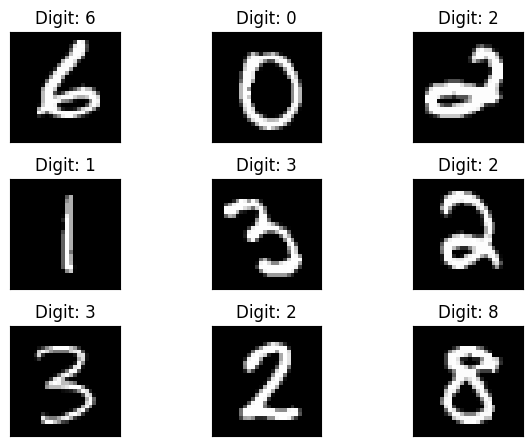

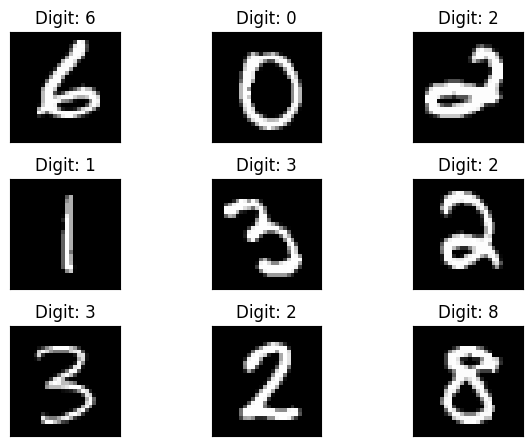

In [ ]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(x_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
d1, d2, d3 = x_train.shape
x_train_flat = x_train.reshape((d1, d2*d3))/255
d1, d2, d3 = x_test.shape
x_test_flat = x_test.reshape((d1, d2*d3))/255
d1, d2, d3 = x_val.shape
x_val_flat = x_val.reshape((d1, d2 * d3)) / 255

print(x_train_flat.shape, x_test_flat.shape, x_val_flat.shape)

(54000, 784) (10000, 784) (6000, 784)


# Búsqueda de hiperparámetros a partir de la búsqueda aleatoria

Ejemplo básico donde el número de capas se define de forma manual

In [ ]:
# Número de épocas para los experimentos
epochs = 10

Definimos el modelo con los hiperparámetros

In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(Dense(units = hp.Choice('units1', [256, 512]), input_shape = (784, ), activation = hp.Choice('activation1', ['relu', 'sigmoid'])))
  model.add(Dense(units = hp.Choice('units2', [256, 512]), activation = hp.Choice('activation2', ['relu', 'sigmoid'])))
  model.add(Dense(10, activation = 'softmax'))
  optimizer = tf.keras.optimizers.SGD(hp.Choice('learning_rate', [0.01, 0.001]))
  model.compile(loss='sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
  return model

In [ ]:
tuner = RandomSearch(build_model, objective = 'val_loss', max_trials = 10)
tuner.search(x_train_flat, y_train, epochs = epochs, validation_data = (x_val_flat, y_val), verbose=2, callbacks=[tf.keras.callbacks.TensorBoard('my_dir')])
best_model = tuner.get_best_models()[0]

Trial 10 Complete [00h 00m 48s]
val_loss: 0.1202731654047966

Best val_loss So Far: 0.1202731654047966
Total elapsed time: 00h 08m 16s


In [ ]:
best_model = tuner.get_best_models()[0]

In [ ]:
print(best_model.layers[0].units, best_model.layers[1].units, best_model.layers[2].units)
print(best_model.layers[0].activation, best_model.layers[1].activation)
print(best_model.optimizer.learning_rate)

512 512 10
<function relu at 0x7f9e3fe7d360> <function relu at 0x7f9e3fe7d360>
<KerasVariable shape=(), dtype=float32, path=SGD/learning_rate>


In [ ]:
test_loss, test_acc = best_model.evaluate(x_test_flat, y_test)
print('test_acc:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9641 - loss: 0.1271
test_acc: 0.9690999984741211


In [ ]:
tuner.get_best_models()

[<Sequential name=sequential, built=True>]